# Notebook to extract place cell information from the dataset

Import the necessary libraries (including the `pynwb` package)

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pynwb

### File reading and information

In [2]:
# Set filepath name to read it with NWB
filepath = Path("data\TestPlitt", "sub-R2_ses-20190219T210000_behavior+ophys_small.nwb")

read_io = pynwb.NWBHDF5IO(filepath, "r")
read_nwbfile = read_io.read()


In [3]:
# Print out file information. This would be from one session
print("Subject info:")
for key, value in read_nwbfile.subject.fields.items():
    print(f"    {key:13}: {value}")

print("\nSession info:")    
print(f"    date/time  : {read_nwbfile.session_start_time}")
print(f"    description: {read_nwbfile.session_description}")

Subject info:
    genotype     : CaMKII-cre hemizygous
    sex          : MALE
    species      : Mus musculus
    subject_id   : R2
    weight       : 23.0 g
    date_of_birth: 2018-11-06 21:00:00-08:00

Session info:
    date/time  : 2019-02-19 21:00:00-08:00
    description: TwoTower_foraging_002_003


### Store some key information

In [4]:
# Neuronal traces from ROIs
ROI_traces = read_nwbfile.processing["ophys"]["Fluorescence"]["RoiResponseSeries"].data
nFrames, nNeurons = ROI_traces.shape
print("{} frames x {} neurons".format(*ROI_traces.shape))

# Deconvolved activity traces
deconvTraces = read_nwbfile.processing["ophys"]["Fluorescence"]["Deconvolved"].data


31932 frames x 2050 neurons


In [5]:
# information of start time for every trial
tstartData = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"]["tstart"].data[()]
nTrials = int(sum(tstartData))
print("Number of trials for this session is: ", nTrials)

# Matrix that stores where the starting points for each trial is
# Useful to divide trials
startIndices = np.where(tstartData)[0]

Number of trials for this session is:  120


In [6]:
# morph value for each trial (total morph taken as base morph + jitter)
baseMorph = read_nwbfile.stimulus["morph"].data[()]
wallJitter = read_nwbfile.stimulus["wallJitter"].data[()]
totalMorph = baseMorph + wallJitter

# Position of the rat over the session
position = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"]["pos"].data[()]

<div class="alert alert-block alert-info"> Important to note we will be using the <b>baseMorph</b> here. It will be used to classify the trials per morph (and get a place cell classification per session per morph value) </div>

#### Define function to positionally bin the data
might be a good idea to vectorize this function

In [8]:
def positionalBin(data, pos):
    bins = np.arange(0, 4.51, 0.1)
    avgResp = np.zeros(len(bins))
    counterArr = np.zeros(len(bins))

    for i in range(len(bins)-1):
        counter = 0 # to keep track of how many data points, to average after accumulation
        for j in range(len(pos)):
            if (bins[i] <= pos[j] < bins[i+1]): # if the position falls within the interval
                avgResp[i] = avgResp[i] + data[j] # keep accumulating the fluoresence data points in this interval
                counter = counter + 1 # keeps track of how many data points are added to average in the end
        if counter != 0: # to avoid dividing by zero if there aren't any datapoints in a bin
            counterArr[i] = counter    # store the counter per positional bin 
            avgResp[i] = avgResp[i]/counter # gets average of the sum after all values in phi have been looped over
    return avgResp, counterArr


In [21]:
# Number of positional bins
nBins = 46

# Creating the dataframe with trials x bins
df = np.zeros([nTrials, nBins])
occp = np.zeros([nTrials, nBins])

# Which cell are we performing the binning on?
cellTrace = deconvTraces[:,0]

# Make sure to add data for last trial DONE
for i in range(nTrials):
    if i < nTrials - 1:
        l = int(startIndices[i])
        r = int(startIndices[i+1])
        df[i,:], occp[i,:] = positionalBin(cellTrace[l:r], position[l:r])
    else:
        l = int(startIndices[i])
        df[i,:], occp[i,:] = positionalBin(cellTrace[l:], position[l:])
    # df[i,:] = cellActivity/np.mean(cellActivity)



In [59]:
trialOccp = np.sum(occp[:,:], axis = 1)
partialOccp = occp / trialOccp.reshape(-1,1)

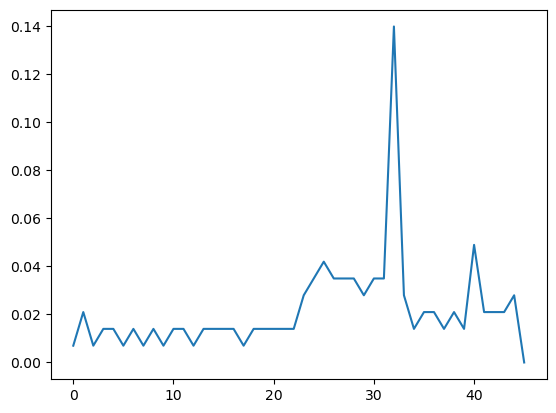

In [62]:
plt.plot(partialOccp[119,:])

### TO DO LIST:
- Return positional occupancy rate per trial (DONE, we have total time per trial in a session and partial occupancy of each bin within a trial)
- Vectorize the binning function
- Binning function can handle all the neurons in the session
- SI calculation with new occupancy rate and aggregated neuronal activity per morph value and occupancy 

### Classify per morph value

The mathematical equation to identify a place cell is using a spatial information metric:

`SI = summ(p_j x lambda_j x log2(lambda_j/lambda))`

Where:
- p_j is the fractional occupancy of each bin j (how much time is spent in each bin)
- lambda_j is the average activity rate of a cell in position bin j 
- lambda is the position-averaged activity rate of the cell

We need to do this for each of the 5 seperate base morph values `S = 0, 0.25, 0.5, 0.75, 1` 

In [63]:


# For one cell, 120 trials
SI = np.zeros(nTrials)

for i in range(nTrials):
    # position-averaged activity rate of the cell across the trial
    lmbda = np.mean(df[i,:])
    logTerm = np.log2((df[i,:]+1e-5)/lmbda) # + 1 necessary due to using deconv data (log2(0) = -inf)
    SIPre = (partialOccp[i,:] * df[i,:] * logTerm)
    SI[i] = np.sum(SIPre)
    

In [64]:
print(SI)

[ 49.18714949  47.70868226  88.87622578  37.26759221  30.19553821
  26.38446311  24.47105801  45.27233931 171.97925587  34.14961293
  35.34646684  69.56728191  34.26989364  28.14226353  43.93019195
  46.13481315  32.56681549  33.92205117  37.13806231  41.66016579
  32.70205569  39.18342078  42.42940314 219.28028837  22.12589315
  30.9620108   35.27236206  42.10447844  33.10644147  35.63585353
  33.29418098  47.45295025  24.51994708  25.28009568  29.25975279
  38.28701987  30.0697723   38.81691435  36.28482884  33.28820362
  10.91673871  16.09456156  33.17038308  38.10149809  38.39718783
  28.61403242 270.10324558  23.40002102  25.9556309   32.36828896
  49.82789215  41.93047599  31.59732085  64.04788087  29.81166058
  34.63636501 254.66754668  35.02270605  21.75671537  40.74075633
  29.92046166  40.12261562  26.17844527  32.55405449 179.82110109
  35.22163293  26.46995725  38.90069819  37.96960994 280.99203492
  33.66566577  80.22367173  26.79764886  41.45864076  25.29014413
 126.89043

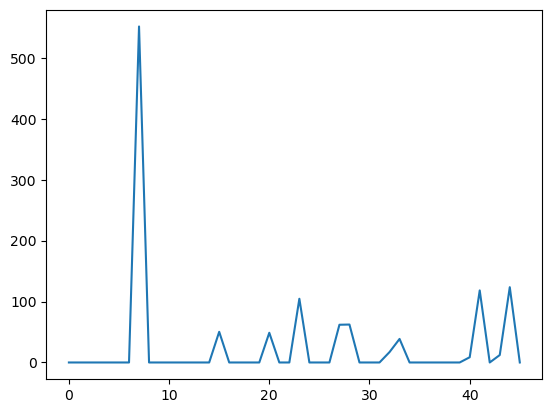

In [65]:
plt.plot(df[-1,:])

In [96]:
aTest = np.array([5, 1, 2, 4, 9, 3, 4, 5])
inds = np.where(aTest <5)[0]
print(np.sum(aTest[inds]))

14


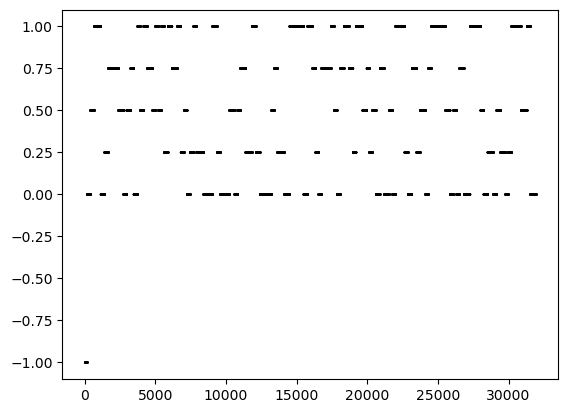

In [108]:
plt.plot(baseMorph, lw=0, marker=".", ms=0.75, color="k", alpha=0.8)

In [124]:
# original numpy matrix
original_matrix = baseMorph

# transform to desired numpy matrix
diff = np.concatenate(([False], original_matrix[1:] != original_matrix[:-1])) # check where values differ
desired_matrix = original_matrix[diff] # extract the differing values

print(baseMorph[startIndices])

[0.   0.5  1.   1.   0.   0.25 0.75 0.75 0.75 0.5  0.   0.5  0.75 0.
 1.   0.5  1.   0.75 0.5  1.   0.5  1.   0.25 1.   0.75 1.   0.25 0.5
 0.   0.25 1.   0.25 0.25 0.   0.   1.   0.25 0.   0.   0.5  0.   0.5
 0.75 0.75 0.25 0.25 1.   0.25 0.   0.   0.5  0.75 0.25 0.25 0.   1.
 1.   1.   0.   1.   0.75 0.25 0.   0.75 0.75 0.75 1.   0.5  0.   0.75
 1.   0.75 0.25 1.   1.   0.5  0.75 0.25 0.5  0.   0.75 0.   0.5  0.
 1.   1.   0.25 0.   0.75 0.25 0.5  0.   0.75 1.   1.   0.5  0.   0.5
 0.   0.75 0.   0.   1.   1.   1.   0.5  0.   0.25 0.   0.5  0.25 0.
 0.25 1.   1.   1.   0.5  1.   0.   0.  ]
